# Preprocessing P9855:  RNA and Protein data

# Loading packages

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_suffix = '.loom'  

In [3]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Getting data

## Getting gene data

Gene data was downloaded [GRCh7 at the biomart](https://grch37.ensembl.org/info/data/biomart/index.html), and we work at the level of distinct Ensembl IDs.  Transcript length (used for TPM normalization) is obtained by averaging all entries with a given Ensembl ID.

In [4]:
def get_genes(filename, verbose=True):
    gene_raw = pd.read_csv(filename, sep='\t', index_col=0, header=0, low_memory=False)
    gene_raw.columns = ['transcript_length', 'gene_name', 'GC_content','transcript stable ID', 'TSS']
    if verbose:
        print('{} genes found in {}.'.format(len(gene_raw), filename))
    
    gene_lengths = gene_raw['transcript_length'].groupby(gene_raw.index).mean()
    gene_GCs = gene_raw['GC_content'].groupby(gene_raw.index).mean()
    gene_df = pd.DataFrame(gene_lengths, index=gene_lengths.index)
    gene_df['GC_content'] = gene_GCs
    gene_df['gene_name'] = gene_raw['gene_name'].groupby(gene_raw.index).first()
    if verbose:
        print('{} distinct Ensembl gene IDs found.'.format(len(gene_df)))
        display(gene_df.head())
    return gene_df

In [5]:
gene_df = get_genes('Raw/GRCh37_Biomart.txt')

215404 genes found in Raw/GRCh37_Biomart.txt.
63677 distinct Ensembl gene IDs found.


,transcript_length,GC_content,gene_name
Gene stable ID,,,
ENSG00000000003,1350.333333,40.87,TSPAN6
ENSG00000000005,940.500000,40.80,TNMD
ENSG00000000419,974.714286,39.85,DPM1
ENSG00000000457,3274.400000,40.14,SCYL3
ENSG00000000460,2197.200000,39.22,C1orf112


Next we load some data that has the location of genes.

In [6]:
gene_metadata = pd.read_csv('Raw/P9855_All_Gene_Info_Metadata.csv', sep=',',
                       index_col=0, header=0, low_memory=False)
print('{} genes loaded.'.format(len(gene_metadata)))
gene_locs = pd.DataFrame(index=gene_metadata.index)
gene_locs['TSS'] = gene_metadata['transcription_start_site']
gene_locs['start'] = gene_metadata['start_position']
gene_locs['end'] = gene_metadata['end_position']
gene_locs['chr'] = gene_metadata['chromosome_name']
gene_locs['dir'] = 1 - 2*((gene_locs['end'] - gene_locs['TSS']) < (gene_locs['TSS'] - gene_locs['start']))
gene_locs['geneid'] = list(gene_locs.index)
gene_locs = gene_locs.loc[~ gene_locs.geneid.duplicated(keep='first')]
gene_locs = gene_locs.drop('geneid', axis=1)
gene_locs.head()

196248 genes loaded.


,TSS,start,end,chr,dir
ensembl_gene_id,,,,,
ENSG00000261657,66119285,66119285,66465398,HG991_PATCH,1
ENSG00000223116,23552136,23551994,23552136,13,-1
ENSG00000233440,23708313,23708313,23708703,13,1
ENSG00000207157,23726825,23726725,23726825,13,-1
ENSG00000229483,23744736,23743974,23744736,13,-1


We put this location data into our gene dataframe.

In [7]:
for col in gene_locs.columns:
    gene_df[col] = gene_locs[col]
gene_df

,transcript_length,GC_content,gene_name,TSS,start,end,chr,dir
Gene stable ID,,,,,,,,
ENSG00000000003,1350.333333,40.87,TSPAN6,99891803,99883667,99894988,X,-1
ENSG00000000005,940.500000,40.80,TNMD,99839799,99839799,99854882,X,1
ENSG00000000419,974.714286,39.85,DPM1,49575087,49551404,49575092,20,-1
ENSG00000000457,3274.400000,40.14,SCYL3,169863093,169818772,169863408,1,-1
ENSG00000000460,2197.200000,39.22,C1orf112,169631245,169631245,169823221,1,1
...,...,...,...,...,...,...,...,...
ENSG00000273489,3731.000000,36.88,RP11-180C16.1,131182453,131178723,131182453,7,-1
ENSG00000273490,1369.857143,59.78,TSEN34,54693789,54693789,54697585,HSCHR19LRC_LRC_J_CTG1,1
ENSG00000273491,3198.000000,39.96,RP11-138A9.2,130600118,130600118,130603315,HG1308_PATCH,1


In [8]:
genes_invivo = ['CD99', 'SELL', 'FCRL6', 'KLRB1', 'NOSIP', 'HLA-DRB1', 'AOAH', 'KLRD1', 'CD28', 'ZNF683', 'IL7R', 'ITM2A', 'FCGR3B', 'LDHB', 'KLRG1', 'PRF1', 'EFHD2', 'MIR4435-1HG', 'CD63', 'TCF7', 'SPON2', 'BZRAP1', 'CAMK4', 'C1orf162', 'RPL4', 'S1PR5', 'CD8B', 'GZMB', 'DFNB31', 'STOM', 'HOPX', 'TMSB4XP8', 'NKG7', 'TSPYL2-1', 'MT-ND5', 'ITGAM', 'ALOX5AP', 'GPR56', 'C1orf228', 'CTSW', 'FGR', 'ANXA2', 'CCL4', 'TTPAL', 'FCGR3A', 'RP11-23P13.6', 'PAX8-AS1', 'AMICA1', 'CCR7', 'EEF1A1P25', 'RPLP0P6', 'ITGAL', 'FGFBP2', 'FOS', 'F2R', 'CD5', 'LAIR2', 'LY6E', 'LGALS1', 'NSG1', 'GAS7', 'FAM211A-AS1', 'DGKA', 'TADA3', 'CD300A', 'LTB', 'ITGB1', 'GZMH', 'RHOH', 'APMAP', 'RPSA', 'LDLRAP1', 'CST7', 'SATB1', 'IL2RB', 'GZMK', 'FLNA-1', 'GNLY', 'TIGIT', 'RPLP0']

In [9]:
TR_gene_df = gene_df[gene_df['gene_name'].str[:3].isin(['TRA','TRB','TRD','TRG','TRJ'])]
TR_gene_df = TR_gene_df.sort_values(by='gene_name')

In [10]:
TR_gene_df.to_csv('TR_gene_data.csv')

In [11]:
TR_gene_df

,transcript_length,GC_content,gene_name,TSS,start,end,chr,dir
Gene stable ID,,,,,,,,
ENSG00000164548,996.636364,41.09,TRA2A,23571660,23544399,23571660,7,-1
ENSG00000136527,1576.125000,38.67,TRA2B,185655924,185633694,185655924,3,-1
ENSG00000170638,2077.666667,62.80,TRABD,50624344,50624344,50638027,22,1
ENSG00000186854,1523.300000,45.98,TRABD2A,85108369,85048774,85134132,2,-1
ENSG00000269113,3826.500000,48.75,TRABD2B,48462567,48226200,48462567,1,-1
...,...,...,...,...,...,...,...,...
ENSG00000249978,353.000000,46.20,TRGV7,38375115,38374642,38375115,7,-1
ENSG00000211696,468.000000,46.37,TRGV8,38370536,38369944,38370536,7,-1
ENSG00000211695,1735.000000,48.35,TRGV9,38358462,38356618,38358462,7,-1


## Loading sample metadata

In [12]:
def get_meta(experiment, filename, report=True, sizemin = 0, sizemax = 10000):
    df = pd.read_csv(filename, sep=',',
                     index_col=2, header=0, low_memory=False)
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    df = df[ df['Number_Of_Cells'] >= sizemin] # At least this many cells.
    df = df[ df['Number_Of_Cells'] <= sizemax] # No more than this many cells
    df.drop(['Project_ID', 'Donor', 'In_Vivo_Clone_ID'], axis=1, inplace=True)
    if report:
        print('{} cell-bulks found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [13]:
meta_df = get_meta('P9855', filename = 'Raw/META_DATA_MARTY_InVitro_FEB8.csv', sizemin = 25, sizemax = 50)

70 cell-bulks found in experiment P9855
24 Clones: P1_A03, P1_A05, P1_A12, P1_D09, P1_D12, P1_F10, P1_H01, P1_H10, P1_A08, P1_B10, P1_C11, P1_F02, P1_F04, P2_A04, P2_B11, P2_D12, P2_F01, P2_G01, P2_G09, P2_H01, P2_H04, P2_H05, P2_A05, P2_C12
The first five rows of the dataframe are below


,Number_Of_Cells,Clone_ID
Sample_ID,,
P9855_2001,25,P1_A03
P9855_2002,25,P1_A03
P9855_2003,25,P1_A03
P9855_2004,25,P1_A05
P9855_2005,25,P1_A05


## Getting expression counts

In [14]:
def get_counts(filename, gdf):
    df = pd.read_csv(filename, sep='\t',
                     index_col=0, header=0, low_memory=False)
    df = df[df.columns[1:]]
    cols = list(df.columns)
    cols = [col[:10] for col in cols]
    df.columns = cols
    return df

In [15]:
counts_df = get_counts('Raw/P9855_JB_merged_gene_counts.tsv', gene_df)
counts_df.head()

,P9855_2019,P9855_2054,P9855_2072,P9855_2025,P9855_2076,P9855_2068,P9855_2006,P9855_2078,P9855_2042,P9855_2063,...,P9855_2009,P9855_2016,P9855_2061,P9855_2015,P9855_2062,P9855_2012,P9855_2080,P9855_2070,P9855_2030,P9855_2031
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print('Expression matrix loaded.')
print('Expression matrix has {} genes,'
      'and {} genes found in gene metadata.'.format(len(counts_df),
                                                    len([gene for gene in counts_df.index if gene in gene_df.index])))
print('Expression matrix has {} samples,'
      'and {} samples found in P9855 metadata.'.format(len(counts_df.columns), 
                                                       len([col for col in counts_df.columns if col in meta_df.index])))


Expression matrix loaded.
Expression matrix has 63677 genes,and 63677 genes found in gene metadata.
Expression matrix has 73 samples,and 70 samples found in P9855 metadata.


In [17]:
counts_df = counts_df[meta_df.index]

## Moving into Scanpy

We move the expression matrices, with information about genes and cells, into Scanpy's AnnData objects.

In [18]:
def moveto_scanpy(counts, cell_meta, gene_meta, plain_name = True):
    adata = sc.AnnData(counts.T)
    for gene_property in gene_meta.columns:
        adata.var[gene_property] = gene_meta[gene_property]
    for cell_property in cell_meta.columns:
        adata.obs[cell_property] = cell_meta[cell_property]
    if plain_name:
        adata.var['ENSG'] = adata.var.index
        adata.var.index = adata.var['gene_name'] # Reindex by gene name
        adata.var_names_make_unique() # Use common gene names, but uniquify them.
    
    return adata

In [19]:
adata = moveto_scanpy(counts_df, meta_df, gene_df)

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD113-1', 'SNORD113-2']
  warnings.warn(


In [20]:
adata

AnnData object with n_obs × n_vars = 70 × 63677
    obs: 'Number_Of_Cells', 'Clone_ID'
    var: 'transcript_length', 'GC_content', 'gene_name', 'TSS', 'start', 'end', 'chr', 'dir', 'ENSG'

In [21]:
adata.var

,transcript_length,GC_content,gene_name,TSS,start,end,chr,dir,ENSG
gene_name,,,,,,,,,
DDX11L1,1356.250000,57.51,DDX11L1,11869,11869,14412,1,1,ENSG00000223972
WASH7P,1560.400000,54.66,WASH7P,29570,14363,29806,1,-1,ENSG00000227232
MIR1302-10,461.666667,48.84,MIR1302-10,29554,29554,31109,1,1,ENSG00000243485
FAM138A,888.500000,50.26,FAM138A,36081,34554,36081,1,-1,ENSG00000237613
OR4G4P,483.000000,36.12,OR4G4P,52473,52473,54936,1,1,ENSG00000268020
...,...,...,...,...,...,...,...,...,...
CYCSP49,319.000000,41.69,CYCSP49,28695572,28695572,28695890,Y,1,ENSG00000224240
SLC25A15P1,342.000000,44.82,SLC25A15P1,28737748,28732789,28737748,Y,-1,ENSG00000227629
PARP4P1,2337.000000,40.94,PARP4P1,28780799,28740998,28780799,Y,-1,ENSG00000237917


In [22]:
adata.var.loc[genes_invivo]['chr'].sort_values()

gene_name
FCGR3A       1
C1orf162     1
FCGR3B       1
C1orf228     1
FGR          1
            ..
MT-ND5      MT
TSPYL2-1     X
ITM2A        X
FLNA-1       X
CD99         X
Name: chr, Length: 80, dtype: object

Now we flop things around to make a Pandas series indexed by ENSG codes with values the (uniquified) gene names.  This will be useful to match ENSG codes with gene names later on (e.g., in ATAC data).

In [23]:
gene_names = pd.DataFrame(adata.var['ENSG'], adata.var.index)
gene_names['gene_name'] = gene_names.index
gene_names.index = gene_names['ENSG']
gene_names = gene_names.gene_name
gene_names

ENSG
ENSG00000223972       DDX11L1
ENSG00000227232        WASH7P
ENSG00000243485    MIR1302-10
ENSG00000237613       FAM138A
ENSG00000268020        OR4G4P
                      ...    
ENSG00000224240       CYCSP49
ENSG00000227629    SLC25A15P1
ENSG00000237917       PARP4P1
ENSG00000231514       FAM58CP
ENSG00000235857       CTBP2P1
Name: gene_name, Length: 63677, dtype: object

In [24]:
gene_names.to_csv('Processed/gene_names.csv') # Save for later.

# Adding TCR information to metadata

In [25]:
TCR_df = pd.read_csv('Raw/In_Vitro_TCR_Data_Dec14.csv', index_col=0, header=0, low_memory=False)
TCR = TCR_df.drop(['Clone ID', 'Cell Number', 'Clone_ID'], axis=1) # Already in metadata.
TCR.head()

,Donor_ID,Method,Vb,D,Jb,TCR Beta,Nuc_Seq_TRB,Va,Ja,TCR Alpha,Nuc_Seq_TRA,Va2,Ja2,TCR Alpha2,Nuc_Seq_TRA_2,Notes
Sample ID,,,,,,,,,,,,,,,,
P1902_1289,D,Smart-seq2,TRBV12-3,D1,TRBJ2-7,CASGTEIFYYEQYF,TGTGCCAGCGGGACAGAAATATTTTACTACGAGCAGTACTTC,TRAV9-2,TRAJ30,CALNDDKIIF,TGTGCTCTGAATGATGACAAGATCATCTTT,NaN,NaN,NaN,NaN,NaN
P1902_1290,D,Smart-seq2,TRBV12-3,D1,TRBJ2-7,CASGTEIFYYEQYF,TGTGCCAGCGGGACAGAAATATTTTACTACGAGCAGTACTTC,TRAV9-2,TRAJ30,CALNDDKIIF,TGTGCTCTGAATGATGACAAGATCATCTTT,NaN,NaN,NaN,NaN,NaN
P1902_1291,D,Smart-seq2,TRBV12-3,D1,TRBJ2-7,CASGTEIFYYEQYF,TGTGCCAGCGGGACAGAAATATTTTACTACGAGCAGTACTTC,TRAV9-2,TRAJ30,CALNDDKIIF,TGTGCTCTGAATGATGACAAGATCATCTTT,NaN,NaN,NaN,NaN,NaN
P1902_1292,D,Smart-seq2,TRBV12-3,D1,TRBJ2-7,CASGTEIFYYEQYF,TGTGCCAGCGGGACAGAAATATTTTACTACGAGCAGTACTTC,TRAV9-2,TRAJ30,CALNDDKIIF,TGTGCTCTGAATGATGACAAGATCATCTTT,NaN,NaN,NaN,NaN,NaN
P1902_1293,D,Smart-seq2,TRBV28,D2,TRBJ1-2,CASSLFIYGYTF,TGTGCCAGCAGTCTCTTCATCTATGGCTACACCTTC,TRAV12-1,TRAJ20,CVVTPDYKLSF,TGTGTGGTGACCCCGGACTACAAGCTCAGCTTT,NaN,NaN,NaN,NaN,NaN


In [26]:
for col in TCR.columns:
    adata.obs[col] = TCR[col] # Tack on metadata.
display(adata.obs.head())

,Number_Of_Cells,Clone_ID,Donor_ID,Method,Vb,D,Jb,TCR Beta,Nuc_Seq_TRB,Va,Ja,TCR Alpha,Nuc_Seq_TRA,Va2,Ja2,TCR Alpha2,Nuc_Seq_TRA_2,Notes
P9855_2001,25,P1_A03,E,Smart-seq2,TRBV10-3,TRBD2,TRBJ2-7,CAISDGGSAYEQYF,TGTGCCATCTCCGACGGGGGGTCTGCCTACGAGCAGTACTTC,TRAV12-2,TRAJ34,CAVTPTDKLIF,TGTGCCGTGACGCCGACCGACAAGCTCATCTTT,TRAV29/DV5,TRAJ21,CAALLPVYNFNKFYF,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,NaN
P9855_2002,25,P1_A03,E,Smart-seq2,TRBV10-3,TRBD2,TRBJ2-7,CAISDGGSAYEQYF,TGTGCCATCTCCGACGGGGGGTCTGCCTACGAGCAGTACTTC,TRAV12-2,TRAJ34,CAVTPTDKLIF,TGTGCCGTGACGCCGACCGACAAGCTCATCTTT,TRAV29/DV5,TRAJ21,CAALLPVYNFNKFYF,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,NaN
P9855_2003,25,P1_A03,E,Smart-seq2,TRBV10-3,TRBD2,TRBJ2-7,CAISDGGSAYEQYF,TGTGCCATCTCCGACGGGGGGTCTGCCTACGAGCAGTACTTC,TRAV12-2,TRAJ34,CAVTPTDKLIF,TGTGCCGTGACGCCGACCGACAAGCTCATCTTT,TRAV29/DV5,TRAJ21,CAALLPVYNFNKFYF,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,NaN
P9855_2004,25,P1_A05,E,Smart-seq2,TRBV4-1,TRBD1,TRBJ2-7,CASSPTGVNAYEQYF,TGCGCCAGCAGCCCGACAGGGGTTAACGCCTACGAGCAGTACTTC,TRAV8-1,TRAJ34,CAVGSYNTDKLIF,TGTGCCGTCGGATCTTATAACACCGACAAGCTCATCTTT,TRAV8-1,TRAJ37,CAVNGSSNTGKLIF,TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT,NaN
P9855_2005,25,P1_A05,E,Smart-seq2,TRBV4-1,TRBD1,TRBJ2-7,CASSPTGVNAYEQYF,TGCGCCAGCAGCCCGACAGGGGTTAACGCCTACGAGCAGTACTTC,TRAV8-1,TRAJ34,CAVGSYNTDKLIF,TGTGCCGTCGGATCTTATAACACCGACAAGCTCATCTTT,TRAV8-1,TRAJ37,CAVNGSSNTGKLIF,TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT,NaN


# Normalization and filtering

In [27]:
print('Identifying highly variable genes.')
sc.pp.highly_variable_genes(adata, n_top_genes=7500, flavor='seurat_v3')

Identifying highly variable genes.


/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


We TPM normalize the expression matrix.

In [28]:
def TPM_norm(ad, target_sum=1e6):
    ad_out = ad.copy()
    
    df = ad_out.to_df().T
    
    # Step 1:  divide each entry by the transcript length of the gene, in kilobases.
    rdf = 1 / ad_out.var['transcript_length']
    df = df.mul(1000*rdf,axis=0) # Multiply by 1000 to convert transcript length to kilobases.
    
    # Transpose for what follows.
    df = df.T
    
    # Step 2:  divide each entry by cell-total, then multiply by target_sum.
    rdf = 1/df.sum(axis=1)
    df = df.mul(rdf, axis=0)
    df = df * target_sum 
    
    # Double-check TPM normalization has succeeded.
    print('The TPM normalization has failed for {} samples.'.format(((df.sum(axis=1) - target_sum) > 0.1).sum()))
    
    # Return new dataframe.
    ad_out.X = df
    return ad_out

In [29]:
adata = TPM_norm(adata)

The TPM normalization has failed for 0 samples.


We keep genes if they are expressed at TPM > 10 for more than 5% of cells.

In [30]:
genes_before = adata.n_vars
gg = ((adata.to_df() > 10).sum() > 0.05*adata.n_obs)
good_genes = gg[gg].index
adata = adata[:,good_genes]
genes_after = adata.n_vars
print('Dataset has {} genes before and {} genes after filtering.'.format(genes_before,genes_after))

Dataset has 63677 genes before and 9680 genes after filtering.


Psuedo-log transformation is next.

In [31]:
sc.pp.log1p(adata)

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:343: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
adata

AnnData object with n_obs × n_vars = 70 × 9680
    obs: 'Number_Of_Cells', 'Clone_ID', 'Donor_ID', 'Method', 'Vb', 'D', 'Jb', 'TCR Beta', 'Nuc_Seq_TRB', 'Va', 'Ja', 'TCR Alpha', 'Nuc_Seq_TRA', 'Va2', 'Ja2', 'TCR Alpha2', 'Nuc_Seq_TRA_2', 'Notes'
    var: 'transcript_length', 'GC_content', 'gene_name', 'TSS', 'start', 'end', 'chr', 'dir', 'ENSG', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

## Dropping T-cell Receptor Genes

We drop all T-cell receptor genes, from an external file.

In [33]:
def drop_TRs(ad, filename='TR_gene_data.csv'):
    ad_out = ad
    TR_gene_df = pd.read_csv(filename, index_col=0)
    TR_genes = TR_gene_df['gene_name'].values
    bad_genes = [gene for gene in ad_out.var_names if gene in TR_genes]
    print('{} genes removed.'.format(len(bad_genes)))
    keep_genes = [gene for gene in ad_out.var_names if not gene in bad_genes]
    ad_out = ad_out[:, keep_genes]
    return ad_out

In [34]:
before_genes = len(adata.var_names)
adata = drop_TRs(adata)
after_genes = len(adata.var_names)
print('{} T-cell receptor genes removed.'.format(before_genes - after_genes))

127 genes removed.
127 T-cell receptor genes removed.


In [35]:
clones = adata.obs.Clone_ID.unique()
clonepops = adata.obs.Clone_ID.value_counts()
bulks = adata.obs_names

print('{} bulks belong to clones with the following populations: \n{}'.format(len(bulks), clonepops))

70 bulks belong to clones with the following populations: 
P1_C11    3
P2_A04    3
P1_A12    3
P1_B10    3
P1_H01    3
P1_A08    3
P1_F02    3
P1_H10    3
P2_D12    3
P1_F04    3
P2_H05    3
P1_D12    3
P1_F10    3
P1_A05    3
P2_F01    3
P2_H04    3
P2_B11    3
P2_A05    3
P1_D09    3
P2_G01    3
P2_H01    3
P2_G09    3
P1_A03    3
P2_C12    1
Name: Clone_ID, dtype: int64


# Quality control

/opt/anaconda3/envs/clonalomics/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


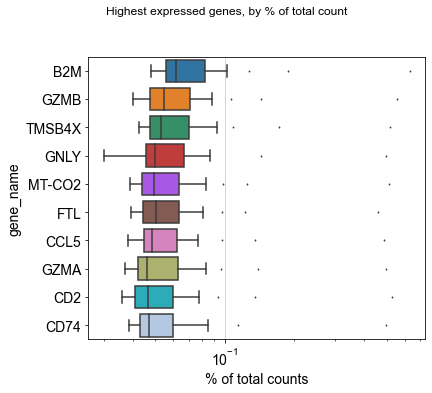

In [36]:
fig,ax = plt.subplots(1,1, figsize=(6,5))
sc.pl.highest_expr_genes(adata, n_top=10, ax=ax, log=True, show=False)
plt.suptitle('Highest expressed genes, by % of total count', y=1.05)
plt.show()

In [37]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

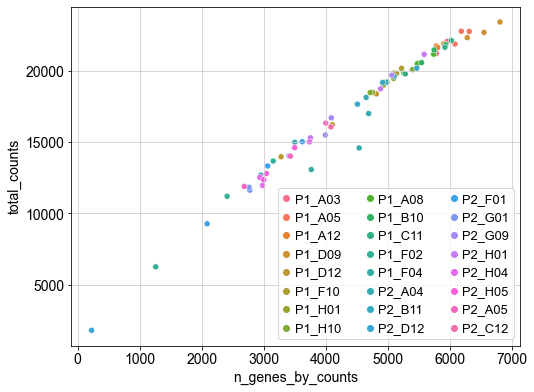

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x='n_genes_by_counts', y='total_counts', hue='Clone_ID', data=adata.obs,  ax=ax)
ax.legend(ncol=3)
plt.show()

We mark the clones with too large a spread of n_genes_by_counts.  

In [39]:
nG_max = adata.obs.groupby('Clone_ID').n_genes_by_counts.max()
nG_min = adata.obs.groupby('Clone_ID').n_genes_by_counts.min()

In [40]:
clones_good = [clone for clone in clones if nG_max[clone] - nG_min[clone] <= 1300]
clones_good = [clone for clone in clones_good if clonepops[clone] == 3]
print('{} clones remaining after {} crazy clones marked.'.format(len(clones_good), len(clones) - len(clones_good)))
bulks_good = [bulk for bulk in bulks if adata.obs.Clone_ID[bulk] in clones_good]
print('{} bulks remain.'.format(len(bulks_good)))

16 clones remaining after 8 crazy clones marked.
48 bulks remain.


In [41]:
adata.obs['Good clone'] = adata.obs_names.isin(bulks_good)
adata.obs['Good clone'].sum() # Should match the number of remaining bulks.

48

# Gene metrics

Here we annotate each gene with metrics which will be used later.  

## Highly variable genes
The first is a ranking for highly variable genes.  Before normalization, we used Scanpy's [highly variable genes](https://scanpy.readthedocs.io/en/stable/api/scanpy.pp.highly_variable_genes.html) function, which annotates the highly variable genes using the methods of Seurat v3. Here we examine the 10 most variable genes.

In [42]:
adata.var.highly_variable_rank.sort_values()[:10]

gene_name
KLRB1       6.0
GZMH        9.0
KIR2DS4    10.0
IFI6       13.0
CAPG       14.0
CCL4       15.0
CSF2       16.0
GNLY       18.0
AMICA1     19.0
ISG15      20.0
Name: highly_variable_rank, dtype: float32

## Clonality statistics

We annotate genes based on statistics for clonality:  ANOVA and Kruskal-Wallis, and chi^2 (after binarization).

In [43]:
def group_stats(ad, groupby='Clone_ID'):
    X = ad.to_df()
    y = ad.obs[groupby]
    F_pvals = ss.f_oneway(*[X[y == k] for k in np.unique(y)])[1]
    print('ANOVA F complete.  Kruskal-Wallis may take a minute now.')
    K_pvals = X.apply(lambda col : ss.kruskal(*[col[y == k] for k in np.unique(y)])[1])
    chi2_pvals = chi2(X > np.log1p(10),y)[1]
    ad_out = ad.copy()
    ad_out.var['F_pval'] = F_pvals
    ad_out.var['K_pval'] = K_pvals
    ad_out.var['chi2_pval'] = chi2_pvals
    return ad_out

We only use bulks from the good clones for clonality statistics.

In [44]:
adata_good = adata[adata.obs['Good clone'], :]

In [45]:
adata_good = group_stats(adata_good)

ANOVA F complete.  Kruskal-Wallis may take a minute now.


In [46]:
adata.var['F_pval'] = adata_good.var['F_pval']

In [47]:
adata.var.F_pval.sort_values()[:10]

gene_name
KIR3DL2    8.463630e-29
CENPN      3.267910e-21
GNLY       8.373333e-17
FKBP1A     1.300491e-14
GZMK       2.386231e-14
KIR2DL4    3.677585e-14
ABCB1      8.066387e-14
CCL5       9.871881e-14
HRH2       1.353997e-12
GZMA       1.571227e-12
Name: F_pval, dtype: float64

# Saving data

Don't forget to save the data!  Here we save data in loom files.

In [48]:
filename = 'Processed/P9855'+file_suffix
adata.write_loom(filename)
print('Data written to {}'.format(filename))

Data written to Processed/P9855.loom


In [49]:
adata

AnnData object with n_obs × n_vars = 70 × 9553
    obs: 'Number_Of_Cells', 'Clone_ID', 'Donor_ID', 'Method', 'Vb', 'D', 'Jb', 'TCR Beta', 'Nuc_Seq_TRB', 'Va', 'Ja', 'TCR Alpha', 'Nuc_Seq_TRA', 'Va2', 'Ja2', 'TCR Alpha2', 'Nuc_Seq_TRA_2', 'Notes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Good clone'
    var: 'transcript_length', 'GC_content', 'gene_name', 'TSS', 'start', 'end', 'chr', 'dir', 'ENSG', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'F_pval'
    uns: 'hvg', 'log1p'

In [50]:
adata.var

,transcript_length,GC_content,gene_name,TSS,start,end,chr,dir,ENSG,highly_variable,...,variances,variances_norm,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,F_pval
gene_name,,,,,,,,,,,,,,,,,,,,,
MTND2P28,1044.000000,43.10,MTND2P28,565020,565020,566063,1,1,ENSG00000225630,False,...,388.754658,0.069281,False,67,2.914273,1.364630,4.285714,203.999100,5.323006,0.500309
hsa-mir-6723,1543.000000,45.76,hsa-mir-6723,566454,566454,567996,1,1,ENSG00000237973,False,...,137.753416,0.087108,False,63,1.529468,0.928009,10.000000,107.062729,4.682712,0.021218
MTATP6P1,681.000000,43.91,MTATP6P1,569076,569076,569756,1,1,ENSG00000248527,False,...,25071.186128,0.411845,False,69,5.431723,1.861243,1.428571,380.220612,5.943378,0.000096
RP11-206L10.9,704.000000,40.42,RP11-206L10.9,714150,714150,745440,1,1,ENSG00000237491,False,...,34.765217,0.635988,False,5,0.185668,0.170307,92.857143,12.996776,2.638827,0.704243
LINC01128,1197.363636,46.34,LINC01128,762988,762988,794826,1,1,ENSG00000228794,False,...,114.340373,0.837090,False,4,0.174432,0.160785,94.285714,12.210242,2.580992,0.667158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMLHE-1,988.166667,37.38,TMLHE,154842597,154719776,154899605,X,-1,ENSG00000185973,False,...,5850.721532,0.975797,False,28,1.438974,0.891577,60.000000,100.728165,4.622304,0.004259
VAMP7,1318.500000,38.78,VAMP7,155110956,155110956,155173433,X,1,ENSG00000124333,True,...,11269.035404,1.187671,False,27,1.467280,0.903116,61.428571,102.709625,4.641595,0.436949
SRIP3,219.000000,50.68,SRIP3,6587221,6587003,6587221,Y,-1,ENSG00000224953,False,...,6.131677,0.035823,False,59,1.854870,1.049026,15.714286,129.840927,4.873982,0.456741


In [51]:
adata.obs

,Number_Of_Cells,Clone_ID,Donor_ID,Method,Vb,D,Jb,TCR Beta,Nuc_Seq_TRB,Va,...,Nuc_Seq_TRA_2,Notes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,Good clone
P9855_2001,25,P1_A03,E,Smart-seq2,TRBV10-3,TRBD2,TRBJ2-7,CAISDGGSAYEQYF,TGTGCCATCTCCGACGGGGGGTCTGCCTACGAGCAGTACTTC,TRAV12-2,...,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,NaN,5954,8.691986,22061.921875,10.001654,165.814499,5.116882,0.751587,True
P9855_2002,25,P1_A03,E,Smart-seq2,TRBV10-3,TRBD2,TRBJ2-7,CAISDGGSAYEQYF,TGTGCCATCTCCGACGGGGGGTCTGCCTACGAGCAGTACTTC,TRAV12-2,...,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,NaN,5494,8.611594,20549.744141,9.930653,173.528809,5.162090,0.844433,True
P9855_2003,25,P1_A03,E,Smart-seq2,TRBV10-3,TRBD2,TRBJ2-7,CAISDGGSAYEQYF,TGTGCCATCTCCGACGGGGGGTCTGCCTACGAGCAGTACTTC,TRAV12-2,...,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,NaN,5785,8.663196,21235.263672,9.963466,159.272446,5.076875,0.750037,True
P9855_2004,25,P1_A05,E,Smart-seq2,TRBV4-1,TRBD1,TRBJ2-7,CASSPTGVNAYEQYF,TGCGCCAGCAGCCCGACAGGGGTTAACGCCTACGAGCAGTACTTC,TRAV8-1,...,TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT,NaN,6084,8.713582,21887.173828,9.993702,160.792206,5.086313,0.734641,True
P9855_2005,25,P1_A05,E,Smart-seq2,TRBV4-1,TRBD1,TRBJ2-7,CASSPTGVNAYEQYF,TGCGCCAGCAGCCCGACAGGGGTTAACGCCTACGAGCAGTACTTC,TRAV8-1,...,TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT,NaN,6186,8.730206,22786.945312,10.033987,164.006638,5.105986,0.719739,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9855_2078,25,P2_H05,E,Smart-seq2,TRBV6-1,TRBD1,TRBJ2-1,CASSQQGAYEQFF,TGTGCCAGTTCTCAACAGGGGGCTTATGAGCAGTTCTTC,TRAV12-2,...,NaN,NaN,3000,8.006701,12368.321289,9.422975,177.537598,5.184799,1.435422,True
P9855_2079,25,P2_A05,E,Smart-seq2,TRBV9,TRBD2,TRBJ2-1,CASSVGGVSYNEQFF,TGTGCCAGCAGCGTGGGCGGGGTCTCCTACAATGAGCAGTTCTTC,TRAV27,...,TGTCTTCTGGGAGATCGGTGTTATGGAGGAAGCCAAGGAAATCTCA...,NaN,3430,8.140607,14020.333984,9.548335,177.411865,5.184095,1.265390,False
P9855_2080,25,P2_A05,E,Smart-seq2,TRBV9,TRBD2,TRBJ2-1,CASSVGGVSYNEQFF,TGTGCCAGCAGCGTGGGCGGGGTCTCCTACAATGAGCAGTTCTTC,TRAV27,...,TGTCTTCTGGGAGATCGGTGTTATGGAGGAAGCCAAGGAAATCTCA...,NaN,2687,7.896553,11898.564453,9.384257,177.764130,5.186067,1.493997,False
P9855_2081,25,P2_A05,E,Smart-seq2,TRBV9,TRBD2,TRBJ2-1,CASSVGGVSYNEQFF,TGTGCCAGCAGCGTGGGCGGGGTCTCCTACAATGAGCAGTTCTTC,TRAV27,...,TGTCTTCTGGGAGATCGGTGTTATGGAGGAAGCCAAGGAAATCTCA...,NaN,4002,8.294799,16338.402344,9.701335,172.787140,5.157831,1.057552,False


In [53]:
file_prefix = 'Processed/'

In [55]:
adata.obs.to_csv(file_prefix+'P9855_SS2_cell_metadata.csv')
adata.var.to_csv(file_prefix+'P9855_SS2_gene_data.csv')
print('Metadata saved for SmartSeq 2 Cells and gene expression.')

Metadata saved for SmartSeq 2 Cells and gene expression.


# Protein preprocessing

In [49]:
protein_df = pd.read_csv('Raw/200912_P9855_exported_29clones_Marty.csv')
protein_df.index = protein_df.index.astype(str)
protein_df

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,CD57 FITC,A2 YF DEXTRA APC,CD8 A7,CD62L BV670,PD1 BV711,CD27 BV786,CD94 PE,CD3 PC5,Plate,SampleID,Clone_Name_Well_ID,Numerical_ID
0,105259.0,80091,86130.5,67739.6,51496,86208.3,35.10130,36305.00,10775.30,-385.35400,3992.0100,-52.4769,6636.170,4298.95,10,8738.39,P1_A03,P9855_01
1,92475.3,70992,85368.2,69652.7,48879,93389.0,0.85517,47706.40,11756.70,-568.81800,3617.4800,-184.0810,3953.090,4749.69,10,8864.71,P1_A03,P9855_01
2,81604.2,65689,81414.1,49733.6,38336,85020.4,695.77600,21582.70,7185.34,-308.38600,3482.8600,-45.8411,5357.150,2791.93,10,8693.79,P1_A03,P9855_01
3,97294.7,77766,81993.5,61924.1,46410,87443.6,7.65006,45342.90,10195.20,-491.16200,3427.4600,-222.0120,8061.690,3602.30,10,8151.98,P1_A03,P9855_01
4,90105.6,70808,83396.8,60173.6,43103,91491.0,1183.69000,23793.00,6965.17,-397.05300,3304.1000,-116.1010,1344.380,2246.38,10,8944.46,P1_A03,P9855_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24208,137537.0,101279,88998.0,77148.1,54711,92412.4,41.45450,13369.40,9492.49,15.94630,265.8990,-93.7598,3902.800,2147.42,10,104565.00,P1_C11,P9855_05a
24209,97417.8,73499,86863.4,76706.2,56404,89125.1,83.79160,9632.08,7345.13,32.96250,257.7290,-62.1399,678.065,1312.12,10,104102.00,P1_C11,P9855_05a
24210,96158.2,76248,82649.1,41762.1,32784,83483.4,270.29600,6020.33,7859.64,-7.64759,250.8340,-145.1850,1609.300,1887.18,10,105353.00,P1_C11,P9855_05a
24211,154706.0,109657,92459.4,104509.0,69252,98901.2,2622.04000,21000.00,10920.90,230.69100,238.8180,-55.3649,2362.050,3205.50,10,105050.00,P1_C11,P9855_05a


In [50]:
protein_df.columns

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD57 FITC',
       'A2 YF DEXTRA APC', 'CD8 A7', 'CD62L BV670', 'PD1 BV711', 'CD27 BV786',
       'CD94 PE', 'CD3 PC5', 'Plate', 'SampleID', 'Clone_Name_Well_ID',
       'Numerical_ID'],
      dtype='object')

In [51]:
pg_dict = {'CD57 FITC' : '',
           'A2 YF DEXTRA APC' : '', 
           'CD8 A7' : 'CD8A',
           'CD62L BV670' : 'SELL', 
           'PD1 BV711' : 'PDCD1',
           'CD27 BV786' : '',
           'CD94 PE' : 'KLRD1',
           'CD3 PC5' : ''}

In [52]:
proteins = list(pg_dict.keys())
proteins

['CD57 FITC',
 'A2 YF DEXTRA APC',
 'CD8 A7',
 'CD62L BV670',
 'PD1 BV711',
 'CD27 BV786',
 'CD94 PE',
 'CD3 PC5']

In [53]:
prot_data = sc.AnnData(protein_df[proteins])
prot_data.var['gene'] = pg_dict.values()
for sample_property in protein_df.columns:
    if sample_property not in proteins:
        prot_data.obs[sample_property] = protein_df[sample_property]

In [54]:
prot_data.obs

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Plate,SampleID,Clone_Name_Well_ID,Numerical_ID
0,105259.0,80091,86130.5,67739.6,51496,86208.3,10,8738.39,P1_A03,P9855_01
1,92475.3,70992,85368.2,69652.7,48879,93389.0,10,8864.71,P1_A03,P9855_01
2,81604.2,65689,81414.1,49733.6,38336,85020.4,10,8693.79,P1_A03,P9855_01
3,97294.7,77766,81993.5,61924.1,46410,87443.6,10,8151.98,P1_A03,P9855_01
4,90105.6,70808,83396.8,60173.6,43103,91491.0,10,8944.46,P1_A03,P9855_01
...,...,...,...,...,...,...,...,...,...,...
24208,137537.0,101279,88998.0,77148.1,54711,92412.4,10,104565.00,P1_C11,P9855_05a
24209,97417.8,73499,86863.4,76706.2,56404,89125.1,10,104102.00,P1_C11,P9855_05a
24210,96158.2,76248,82649.1,41762.1,32784,83483.4,10,105353.00,P1_C11,P9855_05a
24211,154706.0,109657,92459.4,104509.0,69252,98901.2,10,105050.00,P1_C11,P9855_05a


In [55]:
prot_data.obs['Clone_Name_Well_ID'].unique()

array(['P1_A03', 'P1_A05', 'P1_A12', 'P1_D09', 'P1_E09', 'P1_F10',
       'P1_H01', 'P1_H10', 'P1_A08', 'P1_B10', 'P1_F02', 'P1_F04',
       'P1_F12', 'P1_H06', 'P2_A04', 'P2_B11', 'P2_C03', 'P2_D12',
       'P2_F01', 'P2_G01', 'P2_G09', 'P2_H01', 'P2_H04', 'P2_H05',
       'P2_A05', 'P2_C12', 'P1_D12', 'P1_C11'], dtype=object)

In [56]:
adata.obs['Clone_ID'].unique()

array(['P1_A03', 'P1_A05', 'P1_A12', 'P1_D09', 'P1_D12', 'P1_F10',
       'P1_H01', 'P1_H10', 'P1_A08', 'P1_B10', 'P1_C11', 'P1_F02',
       'P1_F04', 'P2_A04', 'P2_B11', 'P2_D12', 'P2_F01', 'P2_G01',
       'P2_G09', 'P2_H01', 'P2_H04', 'P2_H05', 'P2_A05', 'P2_C12'],
      dtype=object)

There are a few more clones in the gene expression data, than in the protein data.  But they should be called the same thing.

In [57]:
prot_data.obs['Clone_ID'] = prot_data.obs['Clone_Name_Well_ID']

In [58]:
prot_data.obs

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Plate,SampleID,Clone_Name_Well_ID,Numerical_ID,Clone_ID
0,105259.0,80091,86130.5,67739.6,51496,86208.3,10,8738.39,P1_A03,P9855_01,P1_A03
1,92475.3,70992,85368.2,69652.7,48879,93389.0,10,8864.71,P1_A03,P9855_01,P1_A03
2,81604.2,65689,81414.1,49733.6,38336,85020.4,10,8693.79,P1_A03,P9855_01,P1_A03
3,97294.7,77766,81993.5,61924.1,46410,87443.6,10,8151.98,P1_A03,P9855_01,P1_A03
4,90105.6,70808,83396.8,60173.6,43103,91491.0,10,8944.46,P1_A03,P9855_01,P1_A03
...,...,...,...,...,...,...,...,...,...,...,...
24208,137537.0,101279,88998.0,77148.1,54711,92412.4,10,104565.00,P1_C11,P9855_05a,P1_C11
24209,97417.8,73499,86863.4,76706.2,56404,89125.1,10,104102.00,P1_C11,P9855_05a,P1_C11
24210,96158.2,76248,82649.1,41762.1,32784,83483.4,10,105353.00,P1_C11,P9855_05a,P1_C11
24211,154706.0,109657,92459.4,104509.0,69252,98901.2,10,105050.00,P1_C11,P9855_05a,P1_C11


In [59]:
prot_data.to_df()

,CD57 FITC,A2 YF DEXTRA APC,CD8 A7,CD62L BV670,PD1 BV711,CD27 BV786,CD94 PE,CD3 PC5
0,35.101299,36305.000000,10775.299805,-385.354004,3992.010010,-52.476898,6636.169922,4298.950195
1,0.855170,47706.398438,11756.700195,-568.817993,3617.479980,-184.080994,3953.090088,4749.689941
2,695.776001,21582.699219,7185.339844,-308.385986,3482.860107,-45.841099,5357.149902,2791.929932
3,7.650060,45342.898438,10195.200195,-491.161987,3427.459961,-222.011993,8061.689941,3602.300049
4,1183.689941,23793.000000,6965.169922,-397.053009,3304.100098,-116.100998,1344.380005,2246.379883
...,...,...,...,...,...,...,...,...
24208,41.454498,13369.400391,9492.490234,15.946300,265.898987,-93.759804,3902.800049,2147.419922
24209,83.791603,9632.080078,7345.129883,32.962502,257.729004,-62.139900,678.065002,1312.119995
24210,270.295990,6020.330078,7859.640137,-7.647590,250.834000,-145.184998,1609.300049,1887.180054
24211,2622.040039,21000.000000,10920.900391,230.690994,238.817993,-55.364899,2362.050049,3205.500000


In [60]:
filename = 'Processed/P9855_protein'+file_suffix
prot_data.write_loom(filename)
print('Data written to {}'.format(filename))

Data written to Processed/P9855_protein.loom


# ATAC 

Now we load up and preprocess the ATAC data.

In [61]:
filename = 'Raw/peakMappingNormCounts_narrowPeaks_edJEM.csv' # Earlier version 'P9855_peakMappingNormCounts.csv'

interval_df = pd.read_csv(filename, sep=',',
                       index_col=0, header=0, low_memory=False)
interval_df.head()
intervals = list(interval_df.index)

We reload the metadata, inlcuding the big ATAC bulks now.

In [62]:
meta_df = pd.read_csv('Raw/P9855_ATAC_RNA_Worksheet_April4_2018n2-1.csv', index_col=0)
meta_df['Clone ID'] = meta_df['Clone ID'].replace(np.nan, 'None') # Keep everything a string
meta_df['Clone_ID'] = meta_df['Clone ID'].apply(lambda x : x[:6]) # Formatting.
print('Metadata loaded on {} samples from P9855'.format(len(meta_df)))
meta_df.head()

Metadata loaded on 114 samples from P9855


,Donor,Condition,HLA Type,Batch,Clone ID,Cell Number,In_Vivo_Clone_Number,Clone_ID_InVitro,founder_pheno,protein_pheno,...,Nuc_Seq_TRA_2,Read_Count.1,notes,Vb2,D.1,Jb2,TRB,sequence,count,Clone_ID
Sample ID,,,,,,,,,,,,,,,,,,,,,
P9855_2001,F,InVitro,A2,1.0,P1_A03,25.0,NaN,P9855_01,EFF,fEFF,...,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A03
P9855_2002,F,InVitro,A2,1.0,P1_A03,25.0,NaN,P9855_01,EFF,fEFF,...,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A03
P9855_2003,F,InVitro,A2,1.0,P1_A03,25.0,NaN,P9855_01,EFF,fEFF,...,TGTGCAGCCTTACTTCCAGTATACAACTTCAACAAATTTTACTTT,262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A03
P9855_2004,F,InVitro,A2,1.0,P1_A05,25.0,NaN,P9855_02,INT,fUND,...,TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A05
P9855_2005,F,InVitro,A2,1.0,P1_A05,25.0,NaN,P9855_02,INT,fUND,...,TGTGCCGTGAATGGCTCTAGCAACACAGGCAAACTAATCTTT,215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A05


In [63]:
new_pheno_df = pd.read_csv('Founder_Phenotype_Final_Nov16_2021.csv', index_col=0)
new_pheno_dict = dict(zip(new_pheno_df.index, new_pheno_df['JakMic_Founder_Pheno_simple']))
new_pheno_dict

{'1': 'INT',
 '2': 'MEM',
 '3': 'INT',
 '4': 'MEM',
 '5a': 'EFF',
 '5b': 'MEM',
 '7': 'MEM',
 '8': 'EFF',
 '9': 'MEM',
 '10': 'INT',
 '11': 'MEM',
 '13': 'MEM',
 '14': 'EFF',
 '15': 'EFF',
 '16': 'EFF',
 '17': 'EFF',
 '18': 'MEM',
 '19': 'INT',
 '20': 'MEM',
 '21': 'MEM',
 '22': 'MEM',
 '23': 'MEM',
 '24': 'MEM'}

In [64]:
interval_df

,Chr,Start,End,Annotation,Distance.to.TSS,Nearest.PromoterID,clone1_R1,clone1_R2,clone10_R1,clone11_R1,...,MA0900.1_HOXA2,MA0901.1_HOXB13,MA0902.1_HOXB2,MA0903.1_HOXB3,MA0905.1_HOXC10,MA0906.1_HOXC12,MA0907.1_HOXC13,MA0908.1_HOXD11,MA0909.1_HOXD13,MA0914.1_ISL2
PeakID,,,,,,,,,,,,,,,,,,,,,
Interval_77062,9,115079369,115080094,intron (ENSG00000119314 intron 1 of 13),15578,ENSG00000119314,8.216276,12.122195,17.707330,18.830673,...,False,False,False,False,False,False,False,False,False,False
Interval_18293,12,117543772,117544007,intron (ENSG00000258285 intron 2 of 2),6603,ENSG00000258285,0.000000,1.212219,0.000000,8.070288,...,False,False,False,False,False,False,False,False,False,False
Interval_51938,3,156852601,156852899,Intergenic,-11957,ENSG00000243629,9.129196,14.546634,8.853665,5.380192,...,False,False,False,False,False,False,False,False,False,False
Interval_33832,19,1671931,1672563,Intergenic,-52393,ENSG00000071564,7.303357,7.879427,4.426832,13.450481,...,False,False,False,False,False,False,False,False,False,False
Interval_13433,11,82996620,82997741,promoter-TSS (ENSG00000137500),73,ENSG00000137500,289.395502,260.021076,258.969696,228.658173,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Interval_8387,10,33622581,33624658,promoter-TSS (ENSG00000099250),-6964,ENSG00000273012,60.252691,79.400375,30.987827,67.252404,...,False,False,False,False,False,False,False,False,False,False
Interval_17712,12,96889476,96890243,intron (ENSG00000188596 intron 1 of 11),-10639,ENSG00000258272,10.042115,2.424439,11.067081,5.380192,...,False,False,True,True,False,False,True,False,True,False
Interval_31505,17,73743896,73744122,intron (ENSG00000132470 intron 3 of 3),17229,ENSG00000108479,1.825839,3.030549,0.000000,8.070288,...,False,False,False,False,False,True,False,False,False,False


We create a dataframe for peak metadata.

In [65]:
peak_meta = pd.DataFrame(index=interval_df.index)
peak_meta['chr'] = interval_df['Chr']
peak_meta['start'] = interval_df['Start']
peak_meta['end'] = interval_df['End']
peak_meta['mid'] = interval_df[['Start','End']].mean(axis=1)

# We create a column for interval type (IType) from the annotations.
annotations = interval_df['Annotation']
interval_types = annotations.apply(lambda A : A[:A.find('(') - 1])
peak_meta['itype'] = interval_types

# We create a column to extract the associated gene from the annotation.
def get_gene(ann):
    if 'ENSG' in ann:
        ensg_loc = ann.find('ENSG')
        return ann[ensg_loc:ensg_loc+15]
    else:
        return None
    
peak_meta['in_ensg'] = interval_df['Annotation'].apply(get_gene)
peak_meta['in_gene'] = peak_meta.in_ensg.map(gene_names)

peaks = list(peak_meta.index)
print('{} peak intervals found.'.format(len(intervals)))
print(interval_types.value_counts())

80599 peak intervals found.
intron          35400
Intergen        21591
promoter-TSS    15359
TTS              4367
exon             3882
Name: Annotation, dtype: int64


In [66]:
peak_meta

,chr,start,end,mid,itype,in_ensg,in_gene
PeakID,,,,,,,
Interval_77062,9,115079369,115080094,115079731.5,intron,ENSG00000119314,PTBP3
Interval_18293,12,117543772,117544007,117543889.5,intron,ENSG00000258285,RP11-103B5.2
Interval_51938,3,156852601,156852899,156852750.0,Intergen,None,NaN
Interval_33832,19,1671931,1672563,1672247.0,Intergen,None,NaN
Interval_13433,11,82996620,82997741,82997180.5,promoter-TSS,ENSG00000137500,CCDC90B
...,...,...,...,...,...,...,...
Interval_8387,10,33622581,33624658,33623619.5,promoter-TSS,ENSG00000099250,NRP1
Interval_17712,12,96889476,96890243,96889859.5,intron,ENSG00000188596,C12orf55
Interval_31505,17,73743896,73744122,73744009.0,intron,ENSG00000132470,ITGB4


## Removing peaks near T-cell Receptor Genes

First we find peaks that are *annotated* to TCR genes.

In [67]:
TR_gene_df = pd.read_csv('TR_gene_data.csv', index_col=0)

In [68]:
TR_genes = TR_gene_df.gene_name
T_peaks_annotated = peak_meta[peak_meta.in_gene.isin(TR_genes)]
T_peaks_annotated

,chr,start,end,mid,itype,in_ensg,in_gene
PeakID,,,,,,,
Interval_21080,14,22465499,22466478,22465988.5,intron,ENSG00000211797,TRAV17
Interval_21116,14,22983397,22984044,22983720.5,promoter-TSS,ENSG00000211861,TRAJ28
Interval_36693,2,3383216,3384111,3383663.5,intron,ENSG00000171853,TRAPPC12
Interval_43164,2,239304166,239304397,239304281.5,intron,ENSG00000204104,TRAF3IP1
Interval_48877,3,42160199,42160671,42160435.0,intron,ENSG00000182606,TRAK1
...,...,...,...,...,...,...,...
Interval_78364,X,13752162,13753414,13752788.0,promoter-TSS,ENSG00000196459,TRAPPC2
Interval_74583,8,141060924,141061238,141061081.0,intron,ENSG00000167632,TRAPPC9
Interval_21091,14,22564267,22564625,22564446.0,intron,ENSG00000211804,TRDV1


Next, we find peaks that are *near* TCR genes (within 50kbp).

In [69]:
T_peaks_near = []
for chrome in TR_gene_df['chr'].unique():
    dist_mat = np.subtract.outer(TR_gene_df[TR_gene_df['chr'] == chrome].TSS.values, 
                                peak_meta[peak_meta['chr'] == chrome].mid.values)
    dist_df = pd.DataFrame(dist_mat, index = TR_gene_df[TR_gene_df['chr'] == chrome].index,
                          columns = peak_meta[peak_meta['chr'] == chrome].index)
    close_ones = (dist_df > -100000) & (dist_df < 100000)
    com = close_ones.max()
    T_peaks_near += list(com[com].index)

In [70]:
len([peak for peak in T_peaks_annotated.index if peak in T_peaks_near]) # Most annotated peaks are near the TSS.

230

In [71]:
len(T_peaks_near)

742

In [72]:
T_peaks = list(set(T_peaks_near) | set(T_peaks_annotated))
len(T_peaks)

749

In [73]:
non_T_peaks = [peak for peak in peak_meta.index if peak not in T_peaks]
len(non_T_peaks)

79857

In [74]:
peak_meta = peak_meta.loc[non_T_peaks]
interval_df = interval_df.loc[non_T_peaks]

In [75]:
def find_sample(clone, s_df = meta_df):
    clonenum = clone[5:-3]
    if (len(clonenum) == 1) or (clonenum[0] == '5'):
        clonenum = '0' + clonenum
    cID = 'P9855_'+clonenum
    matches = s_df[s_df['Clone_ID_InVitro'] == cID]
    matches = matches[matches['Clone ID'].str.contains('ATAC')]
    repl = 'rep' + clone[-1]
    matches_R = matches[matches['Clone ID'].str.contains(repl)]
    if len(matches_R) == 1:
        matches = matches_R        
    if len(matches) != 1:
        print('No unique match found for {}'.format(clone))
        return None
    return matches.index[0]

In [76]:
ATAC_clones = [col for col in interval_df.columns if col[:5] == 'clone']
ATACR_clones = [clone for clone in ATAC_clones if 
                ( (clone[:-1]+'1' in ATAC_clones) and (clone[:-1]+'2' in ATAC_clones))]
parents = [clone[:-3] for clone in ATACR_clones if clone[-1] == '1']
print('{} clones found in ATAC data: {}'.format(len(ATAC_clones), ', '.join(ATAC_clones)))
print('')
print('{} clones have two replicates: {}'.format(len(parents), ', '.join(parents)))

29 clones found in ATAC data: clone1_R1, clone1_R2, clone10_R1, clone11_R1, clone13_R1, clone14_R1, clone15_R1, clone15_R2, clone16_R1, clone17_R1, clone18_R1, clone19_R1, clone2_R1, clone20_R1, clone21_R1, clone22_R1, clone22_R2, clone23_R1, clone23_R2, clone24_R1, clone3_R1, clone4_R1, clone5a_R1, clone5b_R1, clone7_R1, clone8_R1, clone8_R2, clone9_R1, clone9_R2

6 clones have two replicates: clone1, clone15, clone22, clone23, clone8, clone9


In [77]:
ATAC_df = interval_df[ATAC_clones].copy()

In [78]:
ATAC_data = sc.AnnData(ATAC_df.T)
ATAC_data.obs['Is_replicate'] = ATAC_data.obs_names.isin(ATACR_clones)
ATAC_data.obs['Sample_name'] = [find_sample(col) for col in ATAC_data.obs_names]
ATAC_data.obs['ATAC_clone'] = ATAC_data.obs_names
ATAC_data.obs['ATAC_clone'] = [clone[5:] for clone in ATAC_data.obs['ATAC_clone']]
ATAC_data.obs['ATAC_parent'] = ATAC_data.obs['ATAC_clone'].apply(lambda x : x.split('_')[0])
ATAC_data.obs_names = ATAC_data.obs['Sample_name']
ATAC_data.obs.drop('Sample_name', axis=1, inplace=True)
for col in meta_df.columns:
    ATAC_data.obs[col] = meta_df[col]

In [79]:
ATAC_data.obs['founder_pheno'] = ATAC_data.obs['ATAC_parent'].map(new_pheno_dict)

In [80]:
ATAC_data.obs

,Is_replicate,ATAC_clone,ATAC_parent,Donor,Condition,HLA Type,Batch,Clone ID,Cell Number,In_Vivo_Clone_Number,...,Nuc_Seq_TRA_2,Read_Count.1,notes,Vb2,D.1,Jb2,TRB,sequence,count,Clone_ID
Sample_name,,,,,,,,,,,,,,,,,,,,,
P9855_2085,True,1_R1,1,F,InVitro,A2,2.0,P1_A03_ATAC_wellA1_rep1_1000,1000.0,NaN,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A03
P9855_2093,True,1_R2,1,F,InVitro,A2,3.0,P1_A03_ATAC_wellA2_rep2_1000,1000.0,NaN,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A03
P9855_2092,False,10_R1,10,F,InVitro,A2,2.0,P1_A08_ATAC_wellB1_350,350.0,NaN,...,TGCATCGCCGGCCTTCAGGGAGCCCAGAAGCTGGTATTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_A08
P9855_2097,False,11_R1,11,F,InVitro,A2,3.0,P1_B10_ATAC_wellB2_269,269.0,NaN,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_B10
P9855_2099,False,13_R1,13,F,InVitro,A2,3.0,P1_F02_ATAC_wellB4_500,500.0,NaN,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_F02
P9855_2100,False,14_R1,14,F,InVitro,A2,3.0,P1_F04_ATAC_wellB5_500,500.0,P1306_1151,...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P1_F04
P9855_2101,True,15_R1,15,F,InVitro,A2,4.0,P2_A04_ATAC_wellC1_1000_rep1,1000.0,NaN,...,TGTGCCAGCAGCAAAGGGGACAGCTACACTGAAGCTTTCTTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P2_A04
P9855_2102,True,15_R2,15,F,InVitro,A2,4.0,P2_A04_ATAC_wellC2_1000_rep2,1000.0,NaN,...,TGTGCCAGCAGCAAAGGGGACAGCTACACTGAAGCTTTCTTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P2_A04
P9855_2103,False,16_R1,16,F,InVitro,A2,4.0,P2_B11_ATAC_wellC3_700,700.0,NaN,...,TGTGCAATGAGCGGGGGAAAAGGAGGATCAGGATACAGCACCCTCA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P2_B11


In [81]:
ATAC_data.to_df()

PeakID,Interval_77062,Interval_18293,Interval_51938,Interval_33832,Interval_13433,Interval_48454,Interval_27763,Interval_53540,Interval_46169,Interval_46787,...,Interval_58433,Interval_62113,Interval_45676,Interval_43639,Interval_35777,Interval_8387,Interval_17712,Interval_31505,Interval_18056,Interval_10427
Sample_name,,,,,,,,,,,,,,,,,,,,,
P9855_2085,8.216276,0.000000,9.129195,7.303357,289.395508,10.042115,28.300507,26.474667,0.912920,0.000000,...,6.390437,7.303357,20.997150,0.912920,2.738759,60.252689,10.042115,1.825839,7.303357,0.912920
P9855_2093,12.122194,1.212219,14.546634,7.879426,260.021088,3.636658,23.032169,22.426060,2.424439,0.000000,...,9.697756,6.061097,20.607731,0.606110,0.000000,79.400375,2.424439,3.030549,5.454988,0.000000
P9855_2092,17.707329,0.000000,8.853664,4.426832,258.969696,8.853664,39.841492,42.054909,0.000000,0.000000,...,19.920746,2.213416,15.493914,0.000000,0.000000,30.987827,11.067081,0.000000,4.426832,0.000000
P9855_2097,18.830673,8.070289,5.380192,13.450480,228.658173,8.070289,32.281155,21.520769,5.380192,0.000000,...,24.210865,5.380192,34.971249,2.690096,0.000000,67.252403,5.380192,8.070289,5.380192,0.000000
P9855_2099,5.776231,5.776231,6.931477,6.931477,256.464661,5.776231,41.588863,23.104923,3.465739,0.000000,...,9.241969,0.000000,28.881155,2.310492,1.155246,31.191647,11.552462,4.620985,3.465739,0.000000
P9855_2100,5.217534,1.739178,3.478356,10.435068,260.876709,3.478356,38.261917,0.000000,0.000000,0.000000,...,1.739178,8.695890,26.087669,0.000000,5.217534,73.045479,5.217534,3.478356,5.217534,0.000000
P9855_2101,9.334886,0.000000,13.643294,10.771022,294.407928,5.026477,38.057610,1.436136,3.590341,0.000000,...,9.334886,2.872272,19.387840,0.718068,0.000000,18.669771,4.308409,5.744545,5.744545,0.000000
P9855_2102,10.081573,0.000000,24.816181,10.857080,300.120697,11.632586,52.734386,0.775506,3.102023,0.000000,...,9.306068,3.877528,17.061125,0.775506,0.775506,29.469215,3.102023,1.551011,3.877528,0.775506
P9855_2103,8.457537,0.939726,0.000000,14.095895,258.424744,8.457537,55.443851,51.684944,2.819179,0.000000,...,5.638358,3.758905,13.156168,0.000000,2.819179,40.408230,13.156168,1.879453,7.517810,0.000000


In [82]:
ATAC_data.var = peak_meta
ATAC_data.var

,chr,start,end,mid,itype,in_ensg,in_gene
PeakID,,,,,,,
Interval_77062,9,115079369,115080094,115079731.5,intron,ENSG00000119314,PTBP3
Interval_18293,12,117543772,117544007,117543889.5,intron,ENSG00000258285,RP11-103B5.2
Interval_51938,3,156852601,156852899,156852750.0,Intergen,None,NaN
Interval_33832,19,1671931,1672563,1672247.0,Intergen,None,NaN
Interval_13433,11,82996620,82997741,82997180.5,promoter-TSS,ENSG00000137500,CCDC90B
...,...,...,...,...,...,...,...
Interval_8387,10,33622581,33624658,33623619.5,promoter-TSS,ENSG00000099250,NRP1
Interval_17712,12,96889476,96890243,96889859.5,intron,ENSG00000188596,C12orf55
Interval_31505,17,73743896,73744122,73744009.0,intron,ENSG00000132470,ITGB4


In [83]:
ATAC_data.var['max_height'] = ATAC_data.to_df().max()

In [84]:
ATAC_data.var

,chr,start,end,mid,itype,in_ensg,in_gene,max_height
PeakID,,,,,,,,
Interval_77062,9,115079369,115080094,115079731.5,intron,ENSG00000119314,PTBP3,23.361563
Interval_18293,12,117543772,117544007,117543889.5,intron,ENSG00000258285,RP11-103B5.2,8.070289
Interval_51938,3,156852601,156852899,156852750.0,Intergen,None,NaN,30.484531
Interval_33832,19,1671931,1672563,1672247.0,Intergen,None,NaN,16.173389
Interval_13433,11,82996620,82997741,82997180.5,promoter-TSS,ENSG00000137500,CCDC90B,301.373993
...,...,...,...,...,...,...,...,...
Interval_8387,10,33622581,33624658,33623619.5,promoter-TSS,ENSG00000099250,NRP1,118.396484
Interval_17712,12,96889476,96890243,96889859.5,intron,ENSG00000188596,C12orf55,16.138870
Interval_31505,17,73743896,73744122,73744009.0,intron,ENSG00000132470,ITGB4,8.070289


In [85]:
sc.pp.log1p(ATAC_data)

Now we save our ATAC data to a loom file.

In [86]:
filename = 'Processed/P9855_ATAC'+file_suffix
ATAC_data.write_loom(filename)
print('Data written to {}'.format(filename))

Data written to Processed/P9855_ATAC.loom
